In [1]:
import collections
import datetime
import json
import math
import os
import random
import copy
import time
import tempfile
import subprocess
import torch
import torch.utils.data
import torchvision.transforms
import numpy as np
import visdom
import scipy
import einops
import json
from geomloss import SamplesLoss
from torch import nn, optim
from collections import defaultdict
from torch.optim.optimizer import Optimizer, required
from math import sqrt
from functools import partial, lru_cache
from torch.nn import functional as F
from torch.nn import Parameter
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
#dataset defined by my self
class WarriorDataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.image_names = os.listdir(folder_path)
        if transform:
            self.transform = torchvision.transforms.Compose([
                #torchvision.transforms.Resize((70, 70)),
                torchvision.transforms.ToTensor(),
                #torchvision.transforms.Normalize((0, 0, 0), (1, 1, 1))
            ])
    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, index):
        image_name = self.image_names[index]
        image_path = os.path.join(self.folder_path, image_name)
        image = Image.open(image_path)
        image = image.convert("RGB")

        if self.transform:
            image = self.transform(image)
    
        return image
    
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

In [3]:
folder_path = os.getcwd() + "/Pictures/Warrior"
dataset = WarriorDataset(folder_path, transform=True)
train_loader = torch.utils.data.DataLoader(
    dataset,
shuffle=True, batch_size=16, drop_last=True)
train_iterator = iter(cycle(train_loader))

print(dataset[50])

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


In [4]:
args = {
    'width': 32,
    'dataset': 'easy_warrior',
    'n_channels': 3,
    'n_classes': 10,
    'batch_size': 16,
    'vid_batch': 16,
    'latent_dim': 8,  # lower is better modelling but worst interpolation freedom
    'lr': 0.005,
    'log_every': 2
}

In [5]:
if args['dataset'] == 'easy_warrior': # Test case
    xb = next(train_iterator)
    xb = xb.to(device)
else:
    xb,cb = next(train_iterator)
    xb,cb = xb.to(device), cb.to(device)



In [6]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, n_channels):
        super(Decoder, self).__init__()

        self.decoder = nn.Sequential(
            nn.LazyConvTranspose2d(512, 4, stride=1, padding=0),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),  # Output: [512, 4, 4]

            nn.LazyConvTranspose2d(256, 4, stride=2, padding=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),  # Output: [256, 8, 8]

            nn.LazyConvTranspose2d(128, 4, stride=2, padding=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),  # Output: [128, 16, 16]

            nn.LazyConvTranspose2d(64, 4, stride=2, padding=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),  # Output: [64, 32, 32]

            nn.LazyConvTranspose2d(32, 4, stride=2, padding=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),  # Output: [32, 64, 64]

            nn.LazyConvTranspose2d(n_channels, 4, stride=2, padding=1),
            nn.Sigmoid()  # Output: [3, 128, 128]
        )

    def forward(self, z):
        x = self.decoder(z)
        # Crop from [3, 128, 128] to [3, 69, 44]
        x = x[:, :, :44, :69]

        # change n_channels above to match number of colours

        # 0,0,0,0,1,0,0,0,0,
        # softmax(0.3, -0.2, 1.5, ...) -> 0.001, 0.0000, 0.9, 0.00

        # # when implementing the softmax, you'll need to remove the sigmoid then do:
        # may need to view x to make this work
        # x = torch.softmax(x, dim=1)

        # to test your softmax code is working, do
        # x.sum(dim=1) , check this is all 1's
        # inspect say x[0, :, 30, 22] # make sure it looks like a PMF

        # Change n_channels above to match the number of colors

        # Apply softmax to convert the output to a probability distribution
#         x = x.contiguous().view(x.size(0), -1)  # Reshape x to [batch_size, num_features]
        print(x.size())
#         x = torch.softmax(x, dim=1)
#         print(x.sum(dim=1))
#         x = x.view(x.size(0), args['n_channels'], 69, 44)  # Reshape back to [batch_size, n_channels, 69, 44]
#         # Test the softmax code
#         print(x.sum(dim=(1,2,3)))  # Check that the sum is 1 for each channel
#         print(x[0, :, 30, 22])  # Inspect the probability mass function (PMF) for a specific pixel
        return x

net = Decoder(args['latent_dim'], args['n_channels']).to(device)
opt = torch.optim.Adam(net.parameters(), lr=args['lr'])
ot_loss_fn = SamplesLoss("sinkhorn", p=2, blur=0.001)

C:\Users\Nostalgia\anaconda3\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [7]:
def ot_loss(x, y):
    return ot_loss_fn(x.contiguous().view(x.size(0), -1), y.view(y.size(0), -1))

In [8]:
logs = {}
logs['loss1'] = logs['loss2'] = logs['loss3'] = 0
logs['num_stats'] = 0

opt.zero_grad()

# p(x | z)
# p(x | z, p)

p_z = torch.randn(args['batch_size'], args['latent_dim'], 1, 1).to(device)
g = net(p_z)

loss = ot_loss(g, xb)  # ((g-xb)**2).mean()
loss.backward()
opt.step()

torch.Size([16, 3, 44, 69])


In [9]:
g.size()

torch.Size([16, 3, 44, 69])

In [10]:
torch.set_printoptions(profile="full")

In [11]:
# def get_unique_colors(rgb_image):
#     reshaped_image = rgb_image.view(rgb_image.shape[0], -1)
#     unique_colors = torch.unique(reshaped_image, dim=1)
#     num_colors = unique_colors.shape[1]
#     print("Number of unique colors:", num_colors)
#     return unique_colors

# unique_colors = get_unique_colors(dataset[1])
# unique_colors.shape

In [12]:
dataset[0][:,30,30]

tensor([0.3373, 0.0431, 0.1569])

In [13]:
# def rgb_to_palette(rgb_tensor, unique_colors): #rgb_tensor: CHW
#     num_classes = unique_colors.shape[1]
#     onehot = torch.zeros(num_classes, rgb_tensor.shape[1], rgb_tensor.shape[2])
#     for i in range(num_classes):
#         for j in range(rgb_tensor.shape[1]):
#             for k in range(rgb_tensor.shape[2]):
#                 if rgb_tensor[:, j, k].equal(unique_colors[:, i]):
#                     onehot[i, j, k] = 1
                
#     return onehot

# palette_tensor = rgb_to_palette(dataset[0], unique_colors)

# palette_tensor[:, 30, 22]

In [14]:
# def palette_to_rgb(palette_tensor, unique_colors): #palette_tensor: CHW
#     num_classes = unique_colors.shape[1]
#     rgb_tensor = torch.zeros(3, palette_tensor.shape[1], palette_tensor.shape[2])
#     for i in range(num_classes):
#         for j in range(rgb_tensor.shape[1]):
#             for k in range(rgb_tensor.shape[2]):
#                 if palette_tensor[i, j, k] == 1:
#                     rgb_tensor[: , j, k] += unique_colors[:, i] 
    
#     return rgb_tensor

# rgb_tensor = palette_to_rgb(palette_tensor, unique_colors)


In [15]:
# def palette_to_softmax(palette_tensor): #palette_tensor CHW
#     channels = palette_tensor.shape[-3]
#     height = palette_tensor.shape[-2]
#     width = palette_tensor.shape[-1]
#     palette_tensor = palette_tensor.contiguous().view(palette_tensor.size(0), -1)
#     palette_tensor = torch.softmax(palette_tensor, dim=0)
#     #print(palette_tensor.sum(dim=0))
#     #palette_tensor = palette_tensor.view(palette_tensor.size(0), channels, height, width)  # Reshape back to [batch_size, n_channels, 69, 44]
#     palette_tensor = palette_tensor.view(channels, height, width)
    
#     #Test the softmax code
#     #print(palette_tensor.sum(dim=(0)))  # Check that the sum is 1 for each channel
#     print(palette_tensor[:, 30, 22])
#     print(sum(palette_tensor[:, 30, 22]))  # Inspect the probability mass function (PMF) for a specific pixe
#     return palette_tensor

# softmax_tensor = palette_to_softmax(palette_tensor)


In [16]:
# def softmax_to_palette(softmax_tensor): #CHW
#     palette_tensor = torch.zeros(softmax_tensor.shape[-3], softmax_tensor.shape[-2], softmax_tensor.shape[-1])
#     for i in range(softmax_tensor.shape[-2]):
#         for j in range(softmax_tensor.shape[-1]):
#             index = torch.argmax(softmax_tensor[:, i, j])
#             palette_tensor[index, i, j] = 1
    
#     return palette_tensor

# a = softmax_to_palette(softmax_tensor)
# a[:, 30 , 22]

In [17]:
#####For BCHW######
xb.size()
#xb[0, :, 30, 22]

torch.Size([16, 3, 44, 69])

In [18]:
# def batch_get_unique_colors(rgb_image):   # BCHW
#     rgb_image = rgb_image.permute(1, 0, 2, 3)
#     reshaped_image = rgb_image.contiguous().view(rgb_image.shape[0], -1)
#     unique_colors = torch.unique(reshaped_image, dim=1)
#     print(unique_colors.size())
#     num_colors = unique_colors.shape[1]
#     print("Number of unique colors:", num_colors)
#     return unique_colors


In [31]:
# def batch_rgb_to_palette(rgb_tensor, unique_colors): #BCHW
#     num_classes = unique_colors.shape[1]
#     print(num_classes)
    
#     rgb_tensor = rgb_tensor.to(device)
#     unique_colors = unique_colors.to(device)   #ensure they are on the same device
    
#     reshaped_tensor = rgb_tensor.permute(0, 2, 3, 1).contiguous().view(-1, rgb_tensor.shape[1])
#     unique_colors = unique_colors.t()
    
#     print(reshaped_tensor[:, None, :].size())
#     print(unique_colors[None, :, :].size())
    
#     onehot = (reshaped_tensor[:, None, :] == unique_colors[None, :, :]).all(dim=2) #None can add new dim
#     print(reshaped_tensor[:, None, :].size())
#     print(unique_colors[None, :, :].size())
#     print(onehot.size())
#     onehot = onehot.view(rgb_tensor.shape[0], rgb_tensor.shape[2], rgb_tensor.shape[3], num_classes).permute(0, 3, 1, 2).float()
#     print(onehot.size())
    
#     return onehot

# pixel_tensor = batch_rgb_to_palette(xb, palettefile)
# pixel_value = pixel_tensor[0, :, 30, 22]
# print(pixel_value)

38
torch.Size([48576, 1, 3])
torch.Size([1, 38, 3])
torch.Size([48576, 1, 3])
torch.Size([1, 38, 3])
torch.Size([48576, 38])
torch.Size([16, 38, 44, 69])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:0')


In [33]:
# def batch_palette_to_rgb(palette_tensor, unique_colors):
#     num_classes = unique_colors.shape[1]
    
#     palette_tensor = palette_tensor.to(device)
#     unique_colors = unique_colors.to(device)   #ensure they are on the same device
    
#     reshaped_palette = palette_tensor.permute(0, 2, 3, 1).contiguous().view(-1, num_classes)
#     reshaped_unique_colors = unique_colors.t()
    
#     rgb_tensor = torch.matmul(reshaped_palette, reshaped_unique_colors)
#     rgb_tensor = rgb_tensor.view(palette_tensor.shape[0], 3, palette_tensor.shape[2], palette_tensor.shape[3])
    
#     return rgb_tensor


In [21]:
def batch_palette_to_softmax(palette_tensor): #palette_tensor BCHW
    channels = palette_tensor.shape[-3]
    
    reshaped_palette = palette_tensor.permute(0, 2, 3, 1).contiguous().view(-1, channels)
    print(reshaped_palette.size())
    reshaped_palette = torch.softmax(reshaped_palette, dim=1)
    palette_tensor = reshaped_palette.view(palette_tensor.shape[0], palette_tensor.shape[2], palette_tensor.shape[3], channels).permute(0, 3, 1, 2)
    print(palette_tensor.size())
    #Test the softmax code
    print(palette_tensor[0, :, 30, 22])
    print(sum(palette_tensor[4, :, 30, 22]))  # Inspect the probability mass function (PMF) for a specific pixe
    return palette_tensor



In [22]:
def batch_softmax_to_palette(softmax_tensor): #BCHW
    _, indices = torch.max(softmax_tensor, dim=1)
    print(indices.size())
    b, h, w = softmax_tensor.shape[0], softmax_tensor.shape[2], softmax_tensor.shape[3]
    device = softmax_tensor.device  # Ensure both on GPU
    palette_tensor = torch.zeros(b, softmax_tensor.shape[1], h, w, device=device)  
    palette_tensor.scatter_(1, indices.unsqueeze(1), 1)  # indice -> (B, 1, H, W) scatter(dim, index ,src) ？？？
    print(palette_tensor.size())
    return palette_tensor


In [23]:
def check_grad(model):
    for name, param in model.named_parameters():
        if not param.requires_grad:
            print(f"Parameter {name} does not require grad.")

check_grad(net)

In [26]:
if args['dataset'] == 'easy_warrior':
    folder_path = os.getcwd() + "/Pictures/Warrior"
    dataset = WarriorDataset(folder_path, transform=True)
    palettefile = getDatasetPalette(dataset, folder_path)
    train_loader = torch.utils.data.DataLoader(
        dataset,
        shuffle=True, batch_size=args['batch_size'], drop_last=True)
    train_iterator = iter(cycle(train_loader))

Loaded unique colors from file.
torch.Size([3, 38])
Number of unique colors: 38


In [27]:
def getDatasetPalette(dataset, folder_path):
    _, folder_name = os.path.split(folder_path)
    parent_folder, _ = os.path.split(folder_path) #save palette in parent folder
    color_folder_path = os.path.join(parent_folder, "palette_tensors")
    os.makedirs(color_folder_path, exist_ok=True)  
    filename = f"{folder_name}.pt"
    
    file_path = os.path.join(color_folder_path, filename)
    if os.path.exists(file_path):
        # Load if exist
        unique_colors_tensor = torch.load(file_path)
        print("Loaded unique colors from file.")
    else:
        # if not exist, generate palette
        all_colors_list = []
        for rgb_image in dataset:
            reshaped_image = rgb_image.view(3, -1)
            all_colors_list.append(reshaped_image)
        
        all_colors_tensor = torch.cat(all_colors_list, dim=1)  # Concatenate the tensors
        unique_colors_tensor = torch.unique(all_colors_tensor, dim=1)  # Find unique colors

        torch.save(unique_colors_tensor, file_path)
        print("Saved unique colors to file.")
    
    print(unique_colors_tensor.size())
    num_colors = unique_colors_tensor.shape[1]
    print("Number of unique colors:", num_colors)
    return unique_colors_tensor


In [28]:
dataset[1]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0

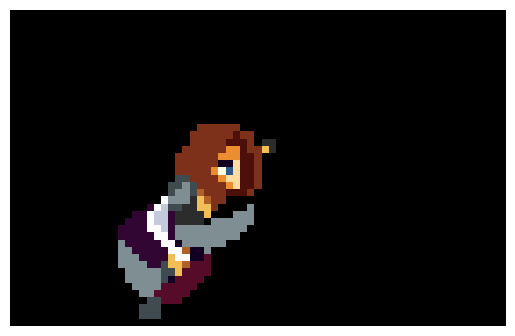

In [42]:
from PIL import Image
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'  # It's neccessary
def tensor_to_image(input_tensor):
    # Clone the tensor and detach it from the current computation graph
    input_tensor = input_tensor.clone().detach()
    # Change the range of the tensor from [0, 1] to [0, 255]
    input_tensor = input_tensor * 255
    # Convert the tensor to uint8 type
    input_tensor = input_tensor.to(torch.uint8)
    # Move the tensor to CPU and convert it to numpy array
    input_numpy = input_tensor.cpu().numpy()
    # Convert the shape of the numpy array from (C, H, W) to (H, W, C)
    input_numpy = input_numpy.transpose((1, 2, 0))
    # Create PIL image from numpy array
    pil_image = Image.fromarray(input_numpy)
    return pil_image

pil_image = tensor_to_image(dataset[5])
plt.imshow(pil_image)
plt.axis('off')  # 去掉坐标轴
plt.show()

In [108]:
def rgb_to_palette(rgb_tensor, unique_colors): #CHW
    num_classes = unique_colors.shape[1]
    
    rgb_tensor = rgb_tensor.to(device)
    unique_colors = unique_colors.to(device)
    
    reshaped_tensor = rgb_tensor.permute(1, 2, 0).contiguous().view(-1, rgb_tensor.shape[0])
    unique_colors = unique_colors.t()
    
    onehot = (reshaped_tensor[:, None, :] == unique_colors[None, :, :]).all(dim=2)
    onehot = onehot.view(rgb_tensor.shape[1], rgb_tensor.shape[2], num_classes).permute(2, 0, 1).float()
    
    return onehot

test_rgb_tensor = dataset[23]
result = rgb_to_palette(test_rgb_tensor, palettefile)
result[:, 20, 20]

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:0')

In [109]:
def palette_to_rgb(palette_tensor, unique_colors): #CHW
    num_classes = unique_colors.shape[1]
    
    palette_tensor = palette_tensor.to(device)
    unique_colors = unique_colors.to(device)
    
    reshaped_palette = palette_tensor.permute(1, 2, 0).contiguous().view(-1, num_classes)
    reshaped_unique_colors = unique_colors.t()
    
    rgb_tensor = torch.matmul(reshaped_palette, reshaped_unique_colors)
    rgb_tensor = rgb_tensor.view(palette_tensor.shape[1], palette_tensor.shape[2], 3).permute(2, 0, 1)
    
    return rgb_tensor

output = palette_to_rgb(result, palettefile)
output.shape

torch.Size([3, 44, 69])

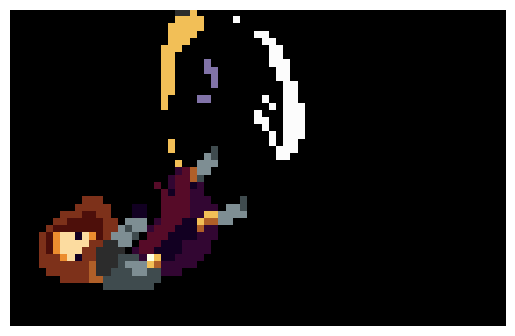

In [110]:
test_image = tensor_to_image(dataset[1])
output_image = tensor_to_image(output)
plt.imshow(output_image)
# plt.imshow(test_image)
plt.axis('off')  # 去掉坐标轴
plt.show()

In [113]:
def palette_to_softmax(palette_tensor): #palette_tensor CHW
    channels, height, width = palette_tensor.shape
    
    reshaped_palette = palette_tensor.permute(1, 2, 0).contiguous().view(-1, channels)
    reshaped_palette = torch.softmax(reshaped_palette, dim=1)
    palette_tensor = reshaped_palette.view(height, width, channels).permute(2, 0, 1)
    
    #Test the softmax code
    print(palette_tensor[:, 30, 22])
    print(torch.sum(palette_tensor[:, 30, 22]))  # Inspect the probability mass function (PMF) for a specific pixel
    
    return palette_tensor

test_softmax_tensor = rgb_to_palette(dataset[1], palettefile)
output_softmax = palette_to_softmax(test_softmax_tensor)

tensor([0.0252, 0.0252, 0.0252, 0.0252, 0.0252, 0.0252, 0.0252, 0.0252, 0.0252,
        0.0252, 0.0252, 0.0252, 0.0252, 0.0252, 0.0684, 0.0252, 0.0252, 0.0252,
        0.0252, 0.0252, 0.0252, 0.0252, 0.0252, 0.0252, 0.0252, 0.0252, 0.0252,
        0.0252, 0.0252, 0.0252, 0.0252, 0.0252, 0.0252, 0.0252, 0.0252, 0.0252,
        0.0252, 0.0252], device='cuda:0')
tensor(1.0000, device='cuda:0')


In [114]:
def softmax_to_palette(softmax_tensor): #CHW
    channels, height, width = softmax_tensor.shape
    
    _, indices = torch.max(softmax_tensor, dim=0)
    palette_tensor = torch.zeros(channels, height, width, device=softmax_tensor.device)  # Ensure both on GPU
    palette_tensor.scatter_(0, indices.unsqueeze(0), 1)  # scatter(dim, index ,src)
    
    print(indices.shape)
    print(palette_tensor.shape)
    
    return palette_tensor

output_palette = softmax_to_palette(output_softmax)
is_same = torch.allclose(test_softmax_tensor, output_palette)
print(is_same)

torch.Size([44, 69])
torch.Size([38, 44, 69])
True
